In [16]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import warnings
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
warnings.filterwarnings('ignore')

In [3]:
url = 'https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=51304980933215218170416&cm_mc_sid_50200000=92178841521817041648&cm_mc_sid_52640000=98592221521817041652'
data = pd.read_csv(url)

In [4]:
print(f'Total Records in our Data :{data.shape[0]}')
print(f'Total Variables in our Data :{data.shape[1]}')
data.head(5).transpose()

Total Records in our Data :7043
Total Variables in our Data :21


,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


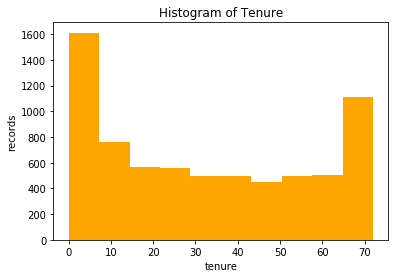

In [5]:
plt.hist(x=data['tenure'],bins=10,color='orange')
plt.xlabel('tenure')
plt.ylabel('records')
plt.title('Histogram of Tenure')
plt.show()

Making dummy variables for churn variable !!

In [6]:
data['churn_dummy'] = data.Churn.apply(lambda x: 1 if x=='Yes' else 0)

In [7]:
data['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [8]:
df = data[data.MultipleLines != 'No phone service']
df['Multiple_lines_dummy'] = df['MultipleLines'].apply(lambda x: 1 if x=='Yes' else 0)
df.Multiple_lines_dummy.value_counts()

0    3390
1    2971
Name: Multiple_lines_dummy, dtype: int64

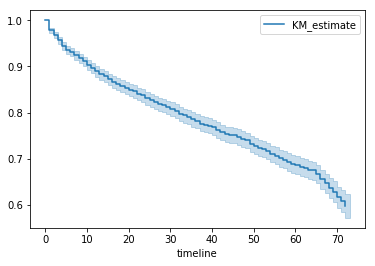

In [9]:
# Multiple Lines
kmf = KaplanMeierFitter()
T = list(df.tenure[df.Multiple_lines_dummy != 0]) 
C = list(df.churn_dummy[df.Multiple_lines_dummy != 0])
kmf.fit(T,C)
kmf.plot()

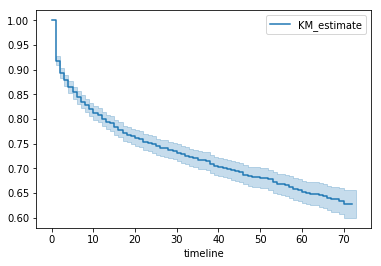

In [10]:
# Multiple Lines
kmf1 = KaplanMeierFitter()
T1 = list(df.tenure[df.Multiple_lines_dummy != 1]) 
C1 = list(df.churn_dummy[df.Multiple_lines_dummy != 1])
kmf1.fit(T1,C1)
kmf1.plot()

In [11]:
d1 = pd.DataFrame(data=kmf.survival_function_)
d2 = pd.DataFrame(data=kmf1.survival_function_)
d1['KMF1_SurvivalFunction'] = d2['KM_estimate']
d1.head(10)

,KM_estimate,KMF1_SurvivalFunction
timeline,,
0.0,1.000000,1.000000
1.0,0.978429,0.918168
2.0,0.968259,0.893251
3.0,0.956675,0.878564
4.0,0.944348,0.865115
5.0,0.936071,0.853750
6.0,0.932260,0.844256
7.0,0.923911,0.835271
8.0,0.917624,0.827537


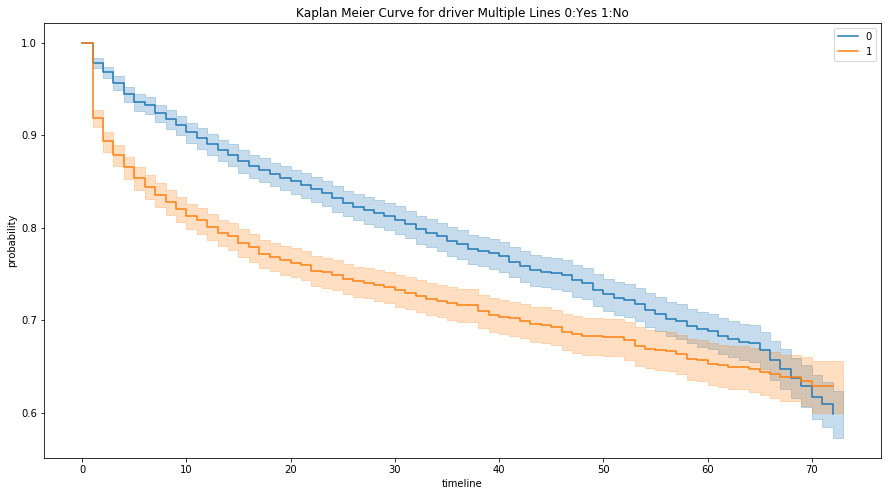

In [12]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()
for group in df['Multiple_lines_dummy'].unique():
    data1 = df[df.Multiple_lines_dummy != group]
    kmf.fit(data1.tenure, data1.churn_dummy, label=group)
    kmf.plot(ax=ax,figsize=(15,8))
    plt.xlabel('timeline',color='black')
    plt.ylabel('probability',color='black')
    plt.title('Kaplan Meier Curve for driver Multiple Lines 0:Yes 1:No')

In [18]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T, event_observed_A=C1, event_observed_B=C)
results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
       31.2627 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [19]:
# Image Credit: https://en.wikipedia.org/wiki/Log-rank_test
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/68750c8d50ac1d055b3ddcc67a05de43b40fdebf")

In [20]:
Z = results.test_statistic
D = df.Multiple_lines_dummy.sum()
hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(f'The Hazard Ratio is {hazard_ratio}')

The Hazard Ratio is 3.149075370470804


Therefore the risk of churn is 3.14 times higher in users with only one phoneline compared to users with multiple lines.